In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
!wget --no-check-certificate --no-cache \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/binary-emotion.csv \
    -O /tmp/binary-emotion.csv

--2021-02-24 10:19:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/binary-emotion.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.211.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2690504 (2.6M) [application/octet-stream]
Saving to: ‘/tmp/binary-emotion.csv’

/tmp/binary-emotion 100%[===================>]   2.57M  --.-KB/s    in 0.02s   

2021-02-24 10:19:55 (105 MB/s) - ‘/tmp/binary-emotion.csv’ saved [2690504/2690504]



In [5]:
sentences=[]
labels=[]
with open('/tmp/binary-emotion.csv', encoding='UTF-8') as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  for row in reader:
    labels.append(int(row[0]))
    sentence = row[1].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)

print(len(labels))
print(len(sentences))

35327
35327


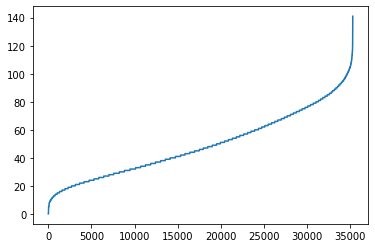

In [10]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.show()

In [11]:
vocab_size = 2000
embedding_dim = 6
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 28000

In [12]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [13]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
wc=tokenizer.word_counts

In [15]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.025), activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/100
875/875 - 2s - loss: 0.7371 - accuracy: 0.5235 - val_loss: 0.6655 - val_accuracy: 0.8241
Epoch 2/100
875/875 - 1s - loss: 0.6923 - accuracy: 0.5235 - val_loss: 0.6581 - val_accuracy: 0.8241
Epoch 3/100
875/875 - 1s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6657 - val_accuracy: 0.8241
Epoch 4/100
875/875 - 1s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6602 - val_accuracy: 0.8241
Epoch 5/100
875/875 - 1s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6509 - val_accuracy: 0.8241
Epoch 6/100
875/875 - 1s - loss: 0.6922 - accuracy: 0.5235 - val_loss: 0.6673 - val_accuracy: 0.8241
Epoch 7/100
875/875 - 1s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6718 - val_accuracy: 0.8241
Epoch 8/100
875/875 - 1s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6578 - val_accuracy: 0.8241
Epoch 9/100
875/875 - 1s - loss: 0.6918 - accuracy: 0.5235 - val_loss: 0.6583 - val_accuracy: 0.8241
Epoch 10/100
875/875 - 1s - loss: 0.6877 - accuracy: 0.5282 - val_loss: 0.6191 - val_accura

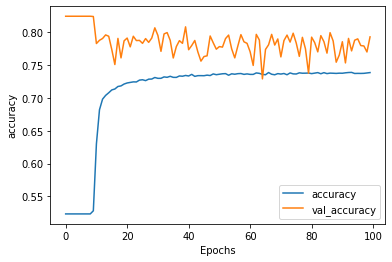

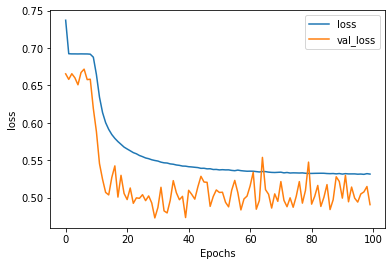

In [18]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
sentence = ["I'm really upset right now and not happy with you! ANGRY!", "She said yes! We're getting married! Wow!"]
sequences = tokenizer.texts_to_sequences(sentence)
print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[1, 22, 526, 57, 4, 1, 3, 55, 1, 1, 1475], [1, 174, 107, 1, 66, 1609, 172]]
[[0.12482718]
 [0.8091407 ]]
